In [14]:
%matplotlib inline
%time from hikyuu.interactive.interactive import *

Wall time: 1e+03 µs


#  1 绘制指标

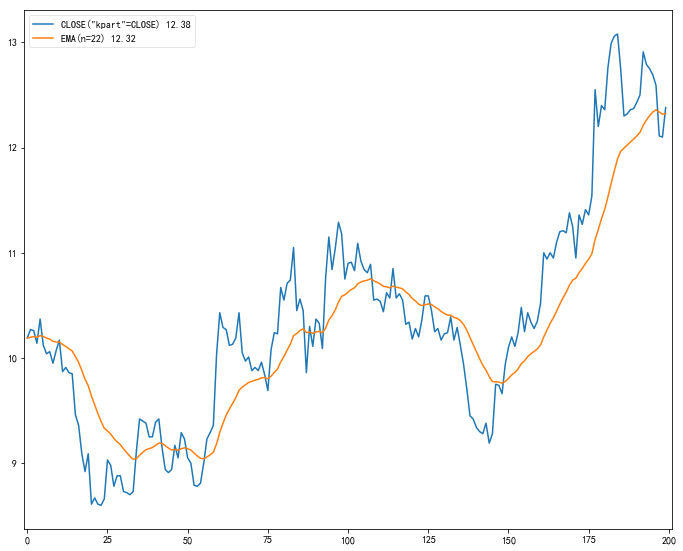

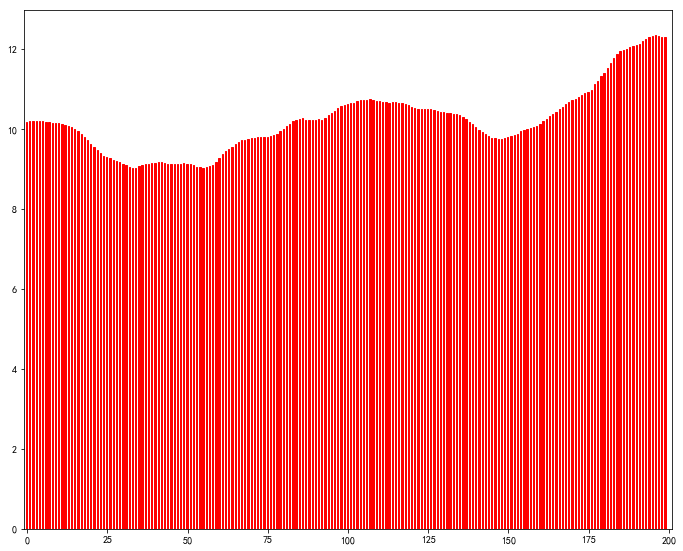

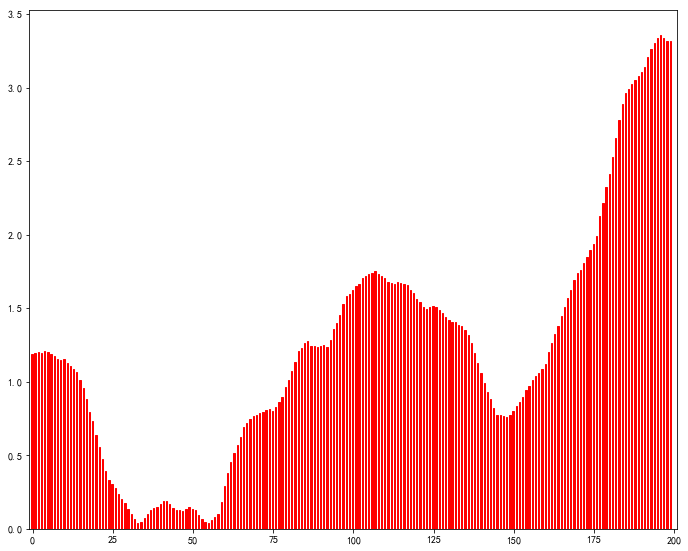

In [15]:
s = sm['sz000001']
k = s.getKData(Query(-200))


#抽取K线收盘价指标，一般指标计算参数只能是指标类型，所以必须先将K线数据生成指标类型
c = CLOSE(k)

#计算收盘价的EMA指标
a = EMA(c)

#绘制指标
c.plot(legend_on=True)
a.plot(new=False, legend_on=True)

#绘制柱状图
a.bar()

#修正下柱状图，使其更美观
PRICELIST([x-9 for x in a]).bar()

# 2 指标（Indicator）

在 Hikyuu 中，Indicator 的实例是用于计算的主要数据结构，一般 ind（如无说明，ind代表Indicator的实例）计算的参数为另一个ind，如EMA(x),x应是一个Indicator的实例。可以简单的理解为类似 numpy.array。

## 2.1 特殊的Indicator

其中存在一类特殊的Indicator，用于将K线数据或普通数组转换为ind，才能供其他ind进行计算，如 KDATA 将 KData 转化为一个ind。其他包括: OPEN,HIGH,LOW,CLOSE,AMO(成交金额),VOL(成交量),KDATA_PART。

In [16]:
print("k is a instance of KData:\n", k)
print("--------------------------\n")

kind = KDATA(k)
print("kind is a instance of Indicator:\n", kind)

k is a instance of KData:
 KData{
  size : 200
  stock: Stock(SZ, 000001, 平安银行, A股, 1, 1991-1-2 0:0:0, +infinity),
  query: KQuery(-200, 9223372036854775807, INDEX, DAY, NO_RECOVER)
 }
--------------------------

kind is a instance of Indicator:
 Indicator(KDATA, params[kdata(KData): SZ000001, kpart(string): KDATA, ])


In [17]:
#获取 ind 的结果集数量，如MACD通常返回3个结果集
r = kind.getResultNumber()
print("result_num: ", r)

#获取第一个结果集
x = kind.getResult(0)
print(x)

result_num:  6
Indicator(IndicatorImp, params[kdata(KData): Null, ])


In [18]:
#以下效果相同
c1 = CLOSE(k)
c2 = KDATA_PART(k, 'close')

另外一个常用的特殊指标 PRICELIST将 Python 中的类 list 对象包装成ind。

In [19]:
x = PRICELIST([i for i in range(100)])
print(len(x), x)

100 Indicator(PRICELIST, params[data(PriceList): 100, discard(int): 0, kdata(KData): Null, result_index(int): 0, ])


## 2.2 Indicator的特性与参数

每一个指标函数，如EMA、HHV，调用后生成一个ind对象，该对象本身可以再次调用生成新的ind。无论指标函数还是 ind 对象调用生成 ind，都是立刻进行计算。如需延迟计算，需使用 Operand 进行包装，可以将 Operand 理解为指标公式进行四则运算的原型，详见后续章节。

In [20]:
e1 = EMA(CLOSE(k), n=5)
e2 = e1(CLOSE(k))
e3 = e2
print(e1 == e2)

Indicator(IndicatorImp, params[kdata(KData): Null, ])


除在指标函数中指定参数外，可以通过 getParam、setParam 方法来获取和修改 ind 对象的参数。修改参数后，ind 本身并不会发生变化，需要调用生成新的 ind，新的 ind 才是使用新参数计算的结果。

Indicator(EMA, params[kdata(KData): Null, n(int): 22, ])
22


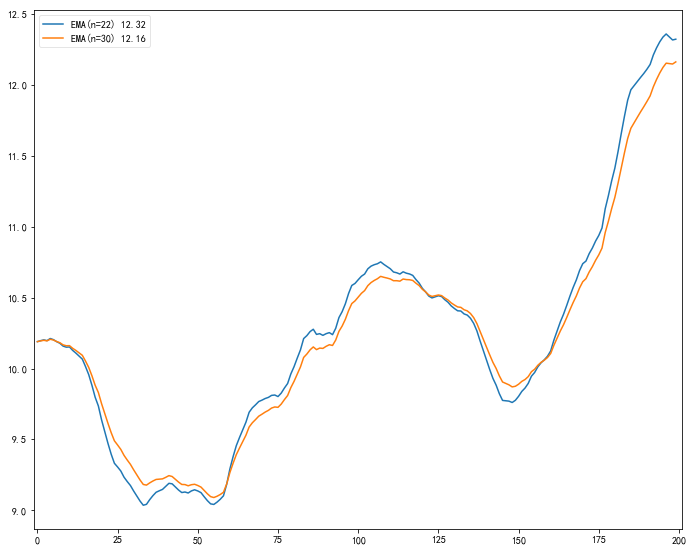

In [21]:
e = EMA(c)
print(e)
print(e.getParam('n'))
e.plot(legend_on=True)

e.setParam('n', 30)
e = e(c)
e.plot(new=False, legend_on=True)

查看 ind 参数。ind 参数支持：

- i : int
- s : str
- b : bool
- d : float

In [22]:
#EMA指标有参数 "n"，类型"i"代表整数
print(EMA())

Indicator(EMA, params[kdata(KData): Null, n(int): 22, ])


## 2.3 TA-Lib包装指标

由于内建指标还不完整，在交互工具里对TA-Lib进行了包装，命名方式统一为 TA_FUNC名称。其中，ta-lib指标的lookback属性，用discard属性代替。

Indicator(TA_SMA, params[kdata(KData): Null, timeperiod(int): 30, ])
29


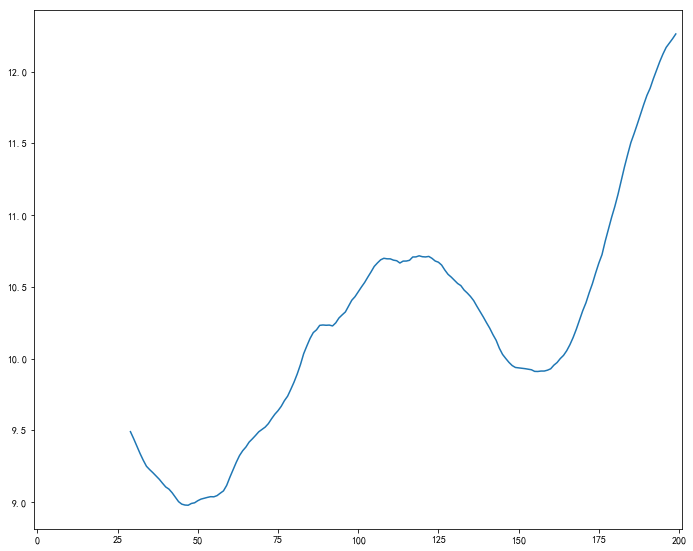

In [23]:
x = TA_SMA(CLOSE(k))
print(x)
x.plot()

print(x.discard)

个别的Ta-Lib函数需要两个数组参数，比如BETA、CORREL。此时需要利用特殊的 Indicator  WEAVE 将两个数组包装到一个 ind 对象中。

2


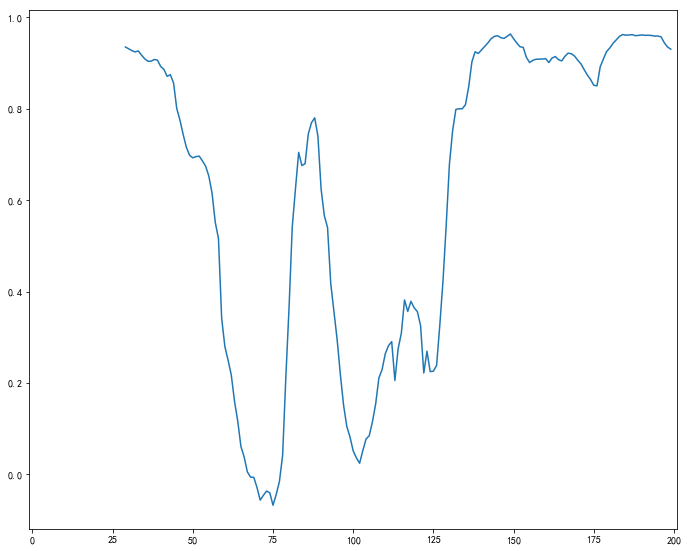

In [24]:
query = Query(-200)
k1 = sm['sh000001'].getKData(query)
k2 = sm['sz000001'].getKData(query)

w = WEAVE(CLOSE(k1), CLOSE(k2))
print(w.getResultNumber())

cr = TA_CORREL(w)
cr.plot()